## IML_Projet_6
Classez des images à l'aide d'algorithmes de Deep Learning

Ce note book contient : 
- La creation et le test de mon propre reseau de neurone CCN 

## Installation libraries

## Data mount drive folder

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs


In [0]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


## Import

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import os

import re

import pickle

import time

from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import scipy.io as sio

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
import cv2 as cv

import tensorflow
print(tensorflow.__version__)

# keras from scratch
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
# keras already trained
from keras.applications.vgg16 import VGG16
# keras image preparation
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
# decode prediction
from keras.applications.vgg16 import decode_predictions
# for training keras model : optimizers
from keras import optimizers
# Keras model base
from keras.models import Model

import json

# ne marche pas (une modif d'une fonction d'un module ne se répercute pas)
# import user module
#from my_utils_dogs import find_breed


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


1.15.0


Using TensorFlow backend.


## Definitions

In [0]:
path_data = '/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/'
path_file_list = 'lists/file_list.mat'
path_test_list = 'lists/test_list.mat'
path_train_list = 'lists/train_list.mat'
path_test_data = 'test_data.mat'
path_train_data = 'train_data.mat'

paths_images_all_breeds = ['Images/n02107683-Bernese_mountain_dog/',
                     'Images/n02088094-Afghan_hound/',
                     'Images/n02096051-Airedale/',
                     'Images/n02090721-Irish_wolfhound/',
                     'Images/n02091831-Saluki/',
                     'Images/n02092002-Scottish_deerhound/',
                     'Images/n02096294-Australian_terrier/',
                     'Images/n02095889-Sealyham_terrier/',
                     'Images/n02095570-Lakeland_terrier/',
                     'Images/n02110185-Siberian_husky/']

nb_breeds = 3
paths_images_breeds = paths_images_all_breeds[:nb_breeds]

path_img_test = path_data + 'Images/n02085620-Chihuahua/' + "n02085620_242.jpg"

path_df_dogs = path_data + 'df_dogs.pkl'
path_X_images = path_data + 'X_images.pkl'
path_Y_images = path_data + 'Y_images.pkl'

name_new_model_2 = 'VGG16_TL_class_01'
path_model_2 = path_data +  name_new_model_2 + '.pkl'

path_df_results = path_data + 'df_results.pkl'

path_imagenet = path_data + 'Images/imagenet_class_index.json'

train_percent = 0.7

## Useful functions

In [0]:
def import_data(paths_images_breeds, train_percent=0.7, force_import=False,
                path_df_dogs=path_df_dogs, path_X_images=path_X_images,
                path_train_list=None):
  '''
  Import data from images on disk

  3 possibilites if force_import = False:
  (1) no data on disk, no data in memory :
    - create df_dogs & X from image files 
    - separate train / test set for df_dogs
  (2) data pickled on disk, no data in memory : 
    - load data from pickled files for df_dogs & X
    - separate train / test set for df_dogs
  (3) data in memory
    - use df_dogs & X from memory 
    - separate train / test set for df_dogs
    - save df_dogs & X on disk
  
  if force_import = True, only  read from image files (1) is possible.

  example: import from memory or already pickled files on disk, with 70% train: 
    df_dogs, X, dict_breed = import_data(paths_images_breeds)
  
  '''
  # import from already processed pickle files on disk
  try:
    if force_import == False:
      df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
      #df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)
      return df_dogs, X, dict_breed 
  except:
    # if not in memory and not on disk
    pass # continue with importation from images files on disk
  

  # import from image files on disk
  df_dogs = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                  'Train'])
  # read images in source folders
  X=None
  for id, path_curr in enumerate(paths_images_breeds):
    breed_curr = re.findall('\w+(?=/$)', path_curr)
    print(breed_curr)
    for filename in os.listdir(path_data + path_curr):
      df_add = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                     "Train"], 
                          index =[0])
      df_add["filename"] = filename
      df_add["path"] = path_data + path_curr + filename
      df_add["breed"] = breed_curr
      df_add["class"] = id
      df_dogs = df_dogs.append(df_add, ignore_index=True)
      # create X image matrix
      img = load_img(df_add["path"].values[0], 
               target_size=(224, 224))  # Charger l'image
      img = img_to_array(img)  # Convertir en tableau numpy
      if X is None:
        X = img[np.newaxis, :]
      X = np.concatenate((X, img[np.newaxis, :]), axis=0)

  # seperate train/test 
  # check test/train mode
  if path_train_list is not None:
    print('Train/Test separation by mat')
    mat_train = sio.loadmat(path_data + path_train_list)
    df_train = pd.DataFrame(data=mat_train["file_list"], 
                           columns=["filename_brut"])
    df_train["filename"] = df_train["filename_brut"].apply(apply_find_filename)
    df_dogs["Train"] = df_dogs["filename"].apply(check_file_train, 
                                                 args=(df_train,))
  else:
    print('Train/Test separation by percent')
    df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)   
  # preprocess image data for VGG-16
  X = preprocess_input(X)

  # find breed name
  dict_breed = dict()
  for id_class in df_dogs["class"].unique(): 
    dict_breed[id_class] = df_dogs[df_dogs["class"] == \
                                 id_class]["breed"].values[0]
  
  # save on disk
  save_data(df_dogs, path_df_dogs, X, path_X_images)

  return df_dogs, X, dict_breed

def check_file_train(filename, df_train):
  '''
  Apply function for dataFrame column to check Train file from data
  '''
  if filename in df_train["filename"].values:
    return True
  else:
    return False

def apply_find_filename(value):
  '''
  apply function for dataFrame column to extract filename from text

  example : 
    [n02085620-Chihuahua/n02085620_5927.jpg]	-> n02085620_5927.jpg
  '''
  return re.findall('(?<=/).+', value[0])[0]

def load_data_breeds(force_reload=False, path_df_dogs=path_df_dogs,
                     path_X_images=path_X_images):
  '''
  Load data from disk if variable df_dogs & X is not available in memory

  Optional parameter force_reload can be use to force reload in any case.

  example : df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
  '''
  # df_dogs
  if force_reload == False:
    try:
      if df_dogs is not None:
        df_out = df_dogs
      else:
        print("Loading from disk df_dogs...")
        df_out = joblib.load(path_df_dogs)
    except:
      print("Loading from disk df_dogs...")
      df_out = joblib.load(path_df_dogs)
  else:
    print("Loading from disk df_dogs...")
    df_out = joblib.load(path_df_dogs)
  # X images
  if force_reload == False:
    try:
      X_out = X
    except:
      print("Loading from disk X images...")
      X_out = joblib.load(path_X_images)
  else:
    print("Loading from disk X images...")
    X_out = joblib.load(path_X_images)

  # find breed name
  dict_breed = dict()
  for id_class in df_out["class"].unique(): 
    dict_breed[id_class] = df_out[df_out["class"] == \
                                 id_class]["breed"].values[0]
  
  return df_out, X_out, dict_breed

def separate_train_by_class(df_dogs, train_percent=0.7):

  '''
  Separate TRAIN / TEST set per breed

  by default train_percent = 0.7

  add "Train" column to df_dogs

  example : df_dogs = separate_train_by_class(df_dogs, train_percent=0.7)
  '''

  df_dogs['Train'] = False
  for id_class in df_dogs["class"].unique():
    np.random.seed(0)
    indices_permut = np.random.permutation(\
      df_dogs[df_dogs["class"] == id_class].shape[0])
    indices_permut_train = \
      indices_permut[0:np.int(len(indices_permut)*train_percent)]
    index_train  = df_dogs[df_dogs["class"] == \
                         id_class].iloc[indices_permut_train].index
    df_dogs.loc[index_train, "Train"] = True

  v= df_dogs["Train"].value_counts()
  print("% of Train : {:.2f} %".format(100*v.loc[True]/sum(v)))
  print(df_dogs["Train"].value_counts())

  return df_dogs

def create_separate_features(df_dogs, X, list_X_classes=None,
                             list_Y_classes=None):
  '''
  Seperate train/test matrix of images to be use by CNN Models
  
  example : 
    X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs, X)
  '''
  # select from df_dogs & X only list of breed : list_X_classes
  def fun_class_ok(classNum):
    if classNum in list_X_classes:
      return True
    else:
      return False
  
  if list_X_classes is not None:
    df_in = df_dogs
    df_in["class_OK"] = False
    df_in["class_OK"] = df_dogs["class"].apply(fun_class_ok)

    df_in = df_in[df_in["class_OK"] == True]
  else:
    df_in = df_dogs
  
  # seperate train/test matrix of images 
  index_train = df_in[df_in["Train"] == True].index
  index_test = df_in[df_in["Train"] == False].index
  X_train = X[index_train,:,:,:]
  X_test = X[index_test,:,:,:]

  # prepare for Y the classes
  if list_Y_classes is None:
    lb = LabelBinarizer()
    lb.fit(df_in["class"].tolist())
    Y_train = lb.transform(df_in[df_in["Train"] == True]["class"].tolist())
    Y_test =  lb.transform(df_in[df_in["Train"] == False]["class"].tolist())
  else:
    # use list_Y_classes
    # lb function
    def lb(x):
      return label_binarize(x, classes=list_Y_classes)
    # transform train set
    Y_train = lb(
        df_in[df_in["Train"] == True]["breed"].tolist())
    # transform test set
    Y_test = lb(
        df_in[df_in["Train"] == False]["breed"].tolist())

  return X_train, X_test, Y_train, Y_test, lb

def load_prepare_img(path_img):
  '''
  Load image from path and prepare for VGG-16
  return : 
    img : np array
    img_raw : Image from PIL

  example : img, img_raw = load_prepare_img(path_img)
  '''

  img_raw = load_img(path_img, target_size=(224, 224))  # Charger l'image
  img = img_to_array(img_raw)  # Convertir en tableau numpy
  img = img[np.newaxis, :]
  img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
  img_raw
  return img, img_raw

def get_imagenet_classes():
  # get labels
  with open(path_imagenet) as json_data:
    class_idx = json.load(json_data)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    # PATCH : to correct double classes
    idx2label[idx2label.index("crane")] = "crane_0"
    idx2label[idx2label.index("maillot")] = "maillot_0"
  return idx2label

In [0]:
def save_data(df_dogs, path_df_dogs, X, path_X_images):
  '''
  Save data on disk : df_dogs & X images

  example : save_data(df_dogs, path_df_dogs, X, path_X_images)

  '''
  joblib.dump(df_dogs, path_df_dogs, compress=True)
  print("df_dogs Saved here:\n{}".format(path_df_dogs))
  joblib.dump(X, path_X_images, compress=True)
  print("X Saved here:\n{}".format(path_X_images))

In [0]:
def predict_breed_from_one_path(path_img, mdl):
  '''
  Predict Breed Name from one image path

  example : breedName = predict_breed_from_one_path(path_img, model)
  '''
  print(path_img)
  img, img_raw = load_prepare_img(path_img)
  y = mdl.predict(img) 
  if y.shape[1] >= 1000:
    breedName = decode_predictions(y, top=3)[0]
    print('VGG-16 : Top 3 :', breedName)
  else:
    print("Probabilities : ", y)
    breedName = find_breed(y, dict_breed)
  print(breedName)
  return breedName, img_raw

  def find_breed(y, dict_breed):
    '''
    Find Breed Name from y output of CNN model
    breed_name = find_breed(y, dict_breed)
    '''
    return dict_breed[np.argmax(y)]

In [0]:
def evaluate_mdl_scorings(Y_train, Y_train_pred,
                          Y_test, Y_test_pred, 
                          timing_fit=0, timing_pred=0):
    dict_scores = dict()
    
    #calculate over same splits f1_micro mean & std
    #cv_lda

    '''
    f1_splits = []
    # on splits test
    for train_index, test_index in cv_lda.split(enc_lda_y_train):
        f1_splits.append(f1_score(enc_lda_y_train[test_index], 
                                  enc_lda_ypred_train[test_index], 
                                  average='micro'))  
    dict_scores["f1_splits_test"] = np.mean(f1_splits)
    dict_scores["f1_splits_test_std"] = np.std(f1_splits)
    '''
    
    # transform as class number 
    Y_train_pred_num = np.argmax(Y_train_pred, axis=1)
    Y_train_num = np.argmax(Y_train, axis=1)
    Y_test_pred_num = np.argmax(Y_test_pred, axis=1)
    Y_test_num = np.argmax(Y_test, axis=1)

    dict_scores["acc_train"] = accuracy_score(Y_train_num, Y_train_pred_num)

    dict_scores["acc_test"] = accuracy_score(Y_test_num, Y_test_pred_num)

    dict_scores["t_fit"] = timing_fit
    dict_scores["t_pred"] = timing_pred
    
    return pd.Series(data = dict_scores)

def add_score(df_results, series_scores, model_name):
    
    df_results_add = pd.DataFrame(data=series_scores, columns=[model_name]).T
    
    if df_results is None: # create table
        print('create df_results')
        df_results = df_results_add.copy()
    else: # update or add line
        try:
            # ligne existe alors on efface l'ancienne ligne  ?
            df_results = df_results.drop(index=model_name)                                
            print('update line')
        except:
            # n'existe pas
            print('add line')
            
        # on ajoute la ligne
        df_results = df_results.append(df_results_add)
        
    return df_results

## Data importation

### Load images of dogs from different folders

In [0]:
force_import = False # only from disk or memory
df_dogs = None # from disk

In [14]:
# import data from disk images & save them into memory and DISK !
df_dogs, X, dict_breed = import_data(paths_images_all_breeds, 
                                     force_import=force_import, 
                                     path_train_list=path_train_list)
# check
print("Image matrix size : ", X.shape)
df_dogs.head()

Loading from disk df_dogs...
Loading from disk X images...
Image matrix size :  (2097, 224, 224, 3)


,filename,path,breed,class,Train
0,n02107683_1175.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False
1,n02107683_1248.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True
2,n02107683_1244.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True
3,n02107683_1003.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False
4,n02107683_1076.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False


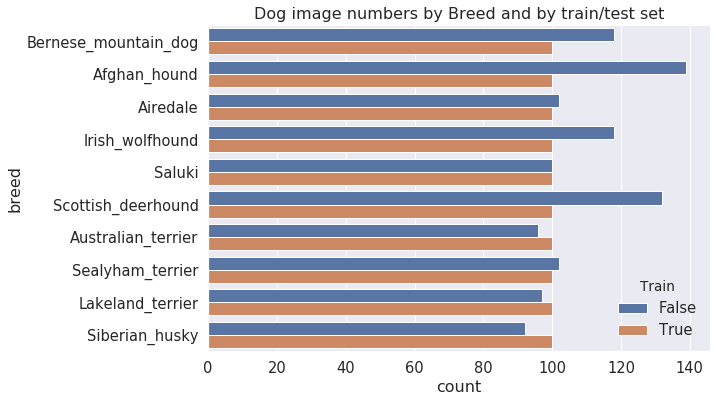

In [15]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 6))
plt.title("Dog image numbers by Breed and by train/test set")
ax = sns.countplot(y="breed", hue="Train", data=df_dogs)

## Keras Neural Network from scratch

Just the first part : Neural Network Structure before fitting process

In [16]:
nb_breeds

3

In [17]:
X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs,
  X, list_X_classes=np.array(range(nb_breeds)))
print("X_train ",X_train.shape)
print("X_test ",X_test.shape)
print("Y_train ",Y_train.shape)
print("Y_test ",Y_test.shape)

X_train  (300, 224, 224, 3)
X_test  (359, 224, 224, 3)
Y_train  (300, 3)
Y_test  (359, 3)


Model: "my_VGG16_01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 224, 224, 16)      1216      
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 224, 224, 16)      6416      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_58 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_115 (Dense)            (None, 100)               313700    
_________________________________________________________________
dense_116 (Dense)            (None, 3)                 303       
Total params: 321,635
Trainable params: 321,635
Non-trainable params: 0
_________________________________________________

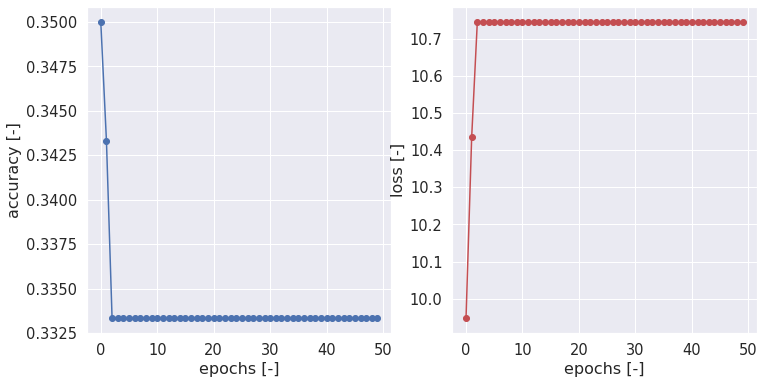

In [227]:
my_VGG16 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16.name = 'my_VGG16_01'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16.add(Conv2D(16, (5, 5), input_shape=(224, 224, 3), padding='same', 
                    activation='relu'))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16.add(Conv2D(16, (5, 5), padding='same', activation='relu'))

# Ajout de la première couche de pooling
#my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # original
my_VGG16.add(MaxPooling2D(pool_size=(16,16), strides=(16,16))) # test
my_VGG16.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16.add(Dense(100, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
#my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16.add(Dense(nb_breeds, activation='softmax'))
print(my_VGG16.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 50
batch_size = None
t_fit_0 = time.time()
# fitting
model_info = my_VGG16.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2)
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(0, len(model_info.history["acc"])), model_info.history["acc"],
         'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info.history['loss'])), model_info.history["loss"],
         'ro-')


Model: "my_VGG16_02"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 75, 75, 16)        1216      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 25, 25, 16)        6416      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_74 (Dense)             (None, 3)                 303       
Total params: 9,635
Trainable params: 9,635
Non-trainable params: 0
_____________________________________________________

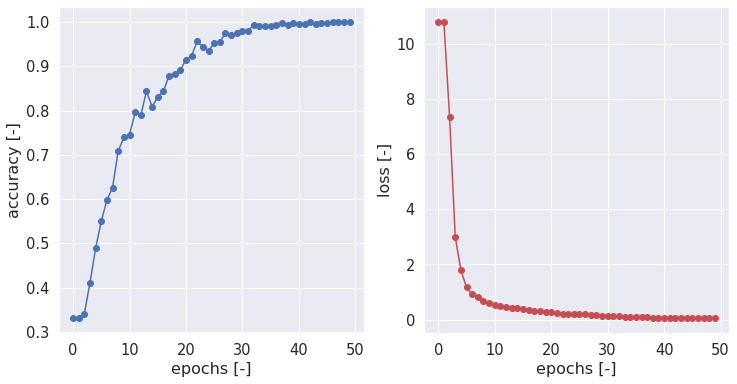

In [0]:
my_VGG16_02 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16_02.name = 'my_VGG16_02'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16_02.add(Conv2D(16, kernel_size=5, strides=3, input_shape=(224, 224, 3),
                       padding='same', activation='relu'))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16_02.add(Conv2D(16, kernel_size=5, strides=3, padding='same', 
                       activation='relu'))

# Ajout de la première couche de pooling
#my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # original
my_VGG16_02.add(MaxPooling2D(pool_size=(16,16), strides=(16,16))) # test
my_VGG16_02.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16_02.add(Dense(100, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
#my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16_02.add(Dense(nb_breeds, activation='softmax'))
print(my_VGG16_02.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16_02.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 50
batch_size = None
t_fit_0 = time.time()
# fitting
model_info_2 = my_VGG16_02.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2)
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(0, len(model_info_2.history["acc"])), 
         model_info_2.history["acc"], 'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info_2.history['loss'])), 
         model_info_2.history["loss"], 'ro-')


In [0]:
# save
joblib.dump(my_VGG16_02, path_data + 'my_VGG16_02.pkl', compress=True)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/my_VGG16_02.pkl']

In [0]:
# load 
my_VGG16_02 = joblib.load(path_data + 'my_VGG16_02.pkl')

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
# predict as binary labels
t_pred_0 = time.time()
Y_train_pred = my_VGG16_02.predict(X_train)
t_pred_1 = time.time()
# predict as binary labels
t_pred_2 = time.time()
Y_test_pred = my_VGG16_02.predict(X_test)
t_pred_3 = time.time()

In [0]:
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

In [0]:
df_results = add_score(df_results, series_scores, my_VGG16_02.name)
df_results

add line


,acc_train,acc_test,t_fit,t_pred
VGG16_TL_class_01,0.990,0.974930,11.906220,1.757683
vgg16,0.771,0.775547,0.000000,5.777447
my_VGG16_02,1.000,0.512563,12.295422,0.835936


In [0]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print("df_results Saved here:\n{}".format(path_df_results))

df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


#### Predict from images

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/Images/n02107683-Bernese_mountain_dog/n02107683_1248.jpg
Probabilities :  [[9.9522650e-01 4.1897157e-03 5.8383163e-04]]
Bernese_mountain_dog


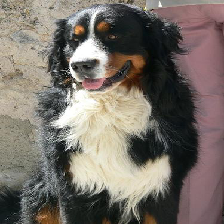

In [0]:
path_img = df_dogs[df_dogs["Train"] == False]["path"].values[0]
breedName, img_raw = predict_breed_from_one_path(path_img, my_VGG16_02)
img_raw

Try to predict a picture from internet :

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Bernese_mountain_dog_01.jpg
Probabilities :  [[1.0000000e+00 5.3052732e-11 2.0185066e-08]]
Bernese_mountain_dog


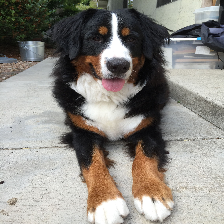

In [0]:
path_img = path_data + '/image_internet_test/Bernese_mountain_dog_01.jpg'
breedName, img_raw = predict_breed_from_one_path(path_img, my_VGG16_02)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Afghan_hound_01.png
Probabilities :  [[0.43600813 0.14792104 0.4160708 ]]
Bernese_mountain_dog


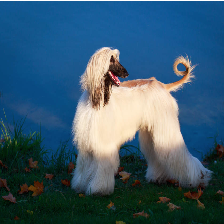

In [0]:
path_img = path_data + '/image_internet_test/Afghan_hound_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, my_VGG16_02)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Airedale_01.png
Probabilities :  [[0.01018371 0.25959554 0.73022074]]
Airedale


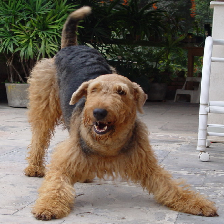

In [0]:
path_img = path_data + '/image_internet_test/Airedale_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, my_VGG16_02)
img_raw

#### Autre test

Model: "my_VGG16_03"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 56, 56, 16)        2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               1254500   
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 

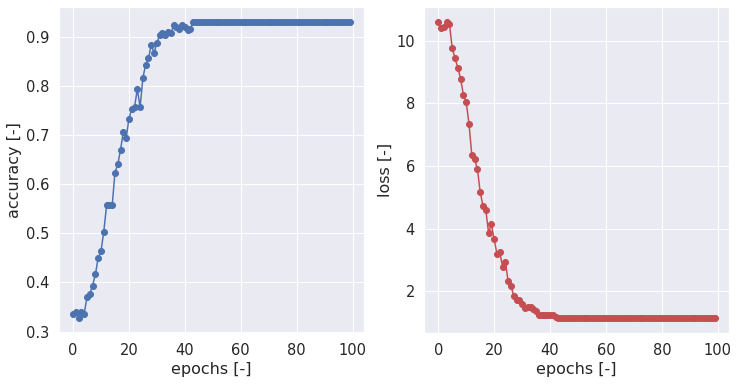

In [23]:
my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16_03.name = 'my_VGG16_03'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16_03.add(Conv2D(16, kernel_size=3, strides=1, input_shape=(224, 224, 3),
                       padding='same', activation='relu'))
my_VGG16_03.add(MaxPooling2D(pool_size=(4,4), strides=(4,4))) # test
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16_03.add(Conv2D(16, kernel_size=3, strides=1, padding='same', 
                       activation='relu'))

# Ajout de la première couche de pooling
#my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # original
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16_03.add(Dense(100, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
#my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16_03.add(Dense(nb_breeds, activation='softmax'))
print(my_VGG16_03.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 100
batch_size = None
t_fit_0 = time.time()
# fitting
model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2)
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(0, len(model_info_3.history["acc"])), 
         model_info_3.history["acc"], 'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info_3.history['loss'])), 
         model_info_3.history["loss"], 'ro-')


In [25]:
# save
joblib.dump(my_VGG16_03, path_data + 'my_VGG16_03.pkl', compress=True)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/my_VGG16_03.pkl']

In [0]:
# load 
my_VGG16_03 = joblib.load(path_data + 'my_VGG16_03.pkl')

In [27]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
# predict as binary labels
t_pred_0 = time.time()
Y_train_pred = my_VGG16_03.predict(X_train)
t_pred_1 = time.time()
# predict as binary labels
t_pred_2 = time.time()
Y_test_pred = my_VGG16_03.predict(X_test)
t_pred_3 = time.time()

In [0]:
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

In [30]:
df_results = add_score(df_results, series_scores, my_VGG16_03.name)
df_results

add line


,acc_train,acc_test,t_fit,t_pred
VGG16_TL_class_01,0.990,0.974930,11.906220,1.757683
vgg16,0.771,0.775547,0.000000,5.777447
my_VGG16_02,1.000,0.512563,12.295422,0.835936
my_VGG16_03,0.930,0.459610,17.716732,0.379260


In [31]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print("df_results Saved here:\n{}".format(path_df_results))

df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


## Compare

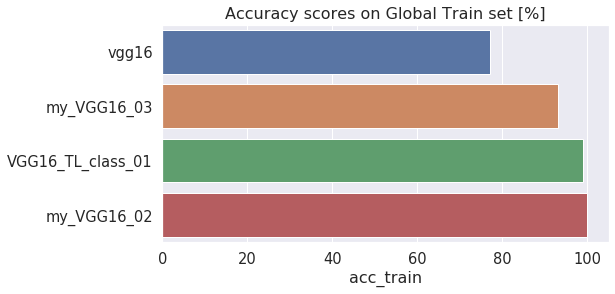

In [32]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Train set [%]")
ax = sns.barplot(
    y=df_results.sort_values(by="acc_train").index,
    x=100*df_results.sort_values(by="acc_train")["acc_train"], orient="h")

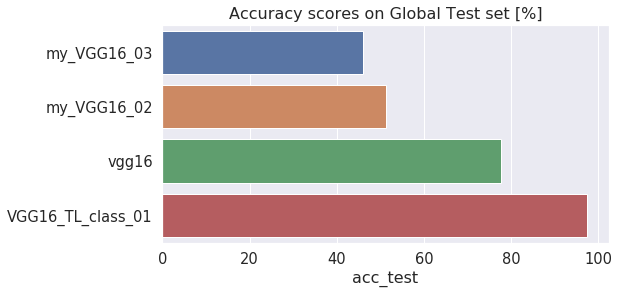

In [33]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Test set [%]")
ax = sns.barplot(
    y=df_results.sort_values(by="acc_test").index,
    x=100*df_results.sort_values(by="acc_test")["acc_test"], orient="h")